In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm
import os, datetime ,json


In [26]:
def pil_from_minus1to1(t):
    """
    Convertit un tenseur [-1,1] (CHW ou 1,C,H,W) en PIL Image.
    """
    t = t.squeeze(0) if t.dim() == 4 else t          # B×C×H×W → C×H×W
    t = ((t.clamp(-1, 1) + 1) / 2)                   # [-1,1] → [0,1]
    return to_pil_image(t.cpu())

In [27]:
def extract_patches(img, patch_size, stride):
    
    img_batch = img.unsqueeze(0)  # (1, C, H, W)
    patches = torch.nn.functional.unfold(img_batch, kernel_size=patch_size, stride=stride)
    patches = patches.squeeze(0).T  # (num_patches, C*patch_size*patch_size)
   
    return patches

def get_gaussian_params(patches, debug=True):
    # patches: Tensor (N, D)
    
    mu = patches.mean(dim=0)
    centered = patches - mu
    Sigma = (centered.T @ centered) / (patches.shape[0] - 1)
    
    return mu, Sigma

import torch

def matrix_sqrt_eig(mat, eps=1e-10, debug=True):
    """
    Symmetric square root of an SPD matrix via eigen-decomposition.
    """
    # 1) Enforce perfect symmetry
    mat = (mat + mat.T) / 2

    # 2) Eigen-decomposition
    vals, vecs = torch.linalg.eigh(mat)
    # 3) Clamp to avoid tiny negatives, then sqrt
    vals = torch.clamp(vals, min=eps)
    sqrt_mat = vecs @ torch.diag(torch.sqrt(vals)) @ vecs.T

    # 4) Re-symmetrize result
    sqrt_mat = (sqrt_mat + sqrt_mat.T) / 2
    

    return sqrt_mat

def wasserstein_2_gaussian_eig(mu1, Sigma1, mu2, Sigma2, eps=1e-12, debug=True):
    """
    Computes W2^2 between two Gaussians (mu1, Sigma1) and (mu2, Sigma2),
    using a robust eigen-based sqrt.
    """
    # Mean term
    diff_mu_sq = torch.norm(mu1 - mu2)**2
    if debug:
        print("moyenne diff =", diff_mu_sq.item())

    # double sinon pas assez précis. 
    A = Sigma1 + eps * torch.eye(Sigma1.size(0), device=Sigma1.device,dtype=torch.float64)
    S1 = matrix_sqrt_eig(A, eps=eps, debug=debug)

    # Inner product √(S1 Σ2 S1)
    prod = S1 @ Sigma2 @ S1
    S2 = matrix_sqrt_eig(prod, eps=eps, debug=debug)

    # Trace term
    trace_term = torch.trace(Sigma1 + Sigma2 - 2 * S2)
    if debug:
        print("trace term =", trace_term.item())

    return diff_mu_sq + trace_term


In [28]:
class Generator(nn.Module):
    
    def __init__(self,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            # Last conv layer outputs 3 channels (RGB), no batchnorm or activation
            nn.Conv2d(self.n_hidden, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self,input):
        return self.main(input)

In [29]:
im_name_to_path = {
    "oiseau" : "images/birds.png",
    "zebre" : "images/zebra.png"
}

In [30]:

# --- (1) nom du modèle à charger -----------------------------------------------------
image_name = "zebre"
model_name = "basic"
model_dir  = os.path.join("models",image_name ,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")  

if not os.path.exists(weights_fp):
    raise FileNotFoundError(f"Impossible de trouver le fichier : {weights_fp}")

# --- (2) on lit la liste de state_dict ----------------------------------------------
state_list = torch.load(weights_fp, map_location="cpu")
print(f"{len(state_list)} générateurs trouvés dans le checkpoint")

# (facultatif) on affiche le petit fichier description
if os.path.isfile(descr_fp):
    print("─── Description.txt ───")
    with open(descr_fp, encoding="utf-8") as f:
        print(f.read().strip())
    print("────────────────────────\n")

# --- (2bis) on charge la liste sigma_n ----------------------------------------------
if os.path.isfile(sigma_fp):
    with open(sigma_fp, "r", encoding="utf-8") as f:
        loaded_sigma_n = json.load(f)
    print(f"sigma_n chargé ({len(loaded_sigma_n)} éléments) → 'loaded_sigma_n'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier sigma_n : {sigma_fp}")

# --- (2ter) on charge z_star -------------------------------------------------------
if os.path.isfile(zstar_fp):
    loaded_z_star = torch.load(zstar_fp, map_location="cpu")
    print(f"z_star chargé de taille {tuple(loaded_z_star.shape)} → 'loaded_z_star'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier z_star : {zstar_fp}")

# --- (3) fonction helper : recrée un Generator adapté au state_dict -----------------
def build_generator_from_state(sd, device="cpu"):
    for key in sd.keys():
        if key.endswith(".weight") and sd[key].dim() == 4:
            n_hidden = sd[key].shape[0]
            break
    else:
        raise KeyError("Impossible d'inférer n_hidden depuis le state_dict.")
    G = Generator(n_hidden).to(device)
    G.load_state_dict(sd, strict=True)
    G.eval()
    for p in G.parameters():
        p.requires_grad_(False)
    return G

# --- (4) on construit la liste des générateurs chargés ------------------------------
device = torch.device("cpu")
loaded_generators = [build_generator_from_state(sd, device=device) for sd in state_list]

print(f"{len(loaded_generators)} générateurs instanciés → 'loaded_generators'")


8 générateurs trouvés dans le checkpoint
─── Description.txt ───
date: 2025-06-02T13:39:24
N: 8
lambda_gp: 10
r: 1.3333333333333333
lr: 0.0005
betas: (0.5, 0.999)
n_Discriminator: 5
n_Generator: 2
iter_per_scale: 2000
alpha_rec: 10
beta_sigma: 0.1
comment: Sin Gan avec poids classique comme dans le papier sauf le padding
────────────────────────

sigma_n chargé (8 éléments) → 'loaded_sigma_n'
z_star chargé de taille (1, 3, 21, 32) → 'loaded_z_star'
8 générateurs instanciés → 'loaded_generators'


In [31]:
loaded_params = {}
with open(descr_fp, encoding="utf-8") as f:
    for line in f:
        if ": " not in line:
            continue
        key, val = line.strip().split(": ", 1)
        loaded_params[key] = val

# Conversion au bon type
loaded_N = int(loaded_params["N"])
loaded_r = float(loaded_params["r"])  

print(f"Hyperparams chargés → N={loaded_N}, r={loaded_r}")


Hyperparams chargés → N=8, r=1.3333333333333333


In [32]:
loaded_params

{'date': '2025-06-02T13:39:24',
 'N': '8',
 'lambda_gp': '10',
 'r': '1.3333333333333333',
 'lr': '0.0005',
 'betas': '(0.5, 0.999)',
 'n_Discriminator': '5',
 'n_Generator': '2',
 'iter_per_scale': '2000',
 'alpha_rec': '10',
 'beta_sigma': '0.1',
 'comment': 'Sin Gan avec poids classique comme dans le papier sauf le padding'}

In [33]:
path = im_name_to_path[image_name]
im = Image.open(path).convert("RGB")
im_tensor_cpu = to_tensor(im).to(device="cpu")

print(f"inital tensor size : {im_tensor_cpu.shape}")


max_dim = 250
_, H, W = im_tensor_cpu.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_cpu.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

inital tensor size : torch.Size([3, 380, 572])
rescaled tensor size : torch.Size([3, 166, 250])


In [34]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(0, loaded_N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / loaded_r), 1)
    new_w = max(int(w / loaded_r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


In [35]:
@torch.no_grad()
def generate_multiscale(start_scale: int = loaded_N - 1,Generators = loaded_generators):
    """
    start_scale = 0  → on ne renouvelle le bruit qu’à la fine scale
    start_scale = N-1→ on renouvelle le bruit à toutes les échelles
    """
    # Génération totale
    if start_scale == loaded_N-1 : 
        h, w = scales[-1].shape[2:]
        gen_image = [torch.zeros((1, 3, h, w), device=device)]

         # 2. on remonte coarse → fine
        for i in range(loaded_N):
            k = loaded_N - 1 - i                    
        
            prev = gen_image[-1]
            if prev.shape[2:] != scales[k].shape[2:]:
                prev = F.interpolate(prev, size=scales[k].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * loaded_sigma_n[k]
            

            x_k = Generators[k](z + prev) + prev
            gen_image.append(x_k)

        

    else : 
        low = scales[start_scale+1] 
        up = F.interpolate(low, size=scales[start_scale].shape[2:],
                                    mode='bilinear', align_corners=False)
        gen_image = [up]

         # 2. on remonte coarse → fine
        for scale in range(start_scale,-1,-1):
                            
            prev = gen_image[-1]
            if prev.shape[2:] != scales[scale].shape[2:]:
                prev = F.interpolate(prev, size=scales[scale].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * loaded_sigma_n[scale]
            x_k = Generators[scale](z + prev) + prev
            gen_image.append(x_k)

    
    return gen_image[1:]
        
    


In [36]:
# Cell 2: Génération et stockage des échantillons
out_dir = "outputs/" + image_name
os.makedirs(out_dir, exist_ok=True)

K = 8
final_imgs = []
for k in range(K):
    imgs = generate_multiscale(start_scale=loaded_N-1, Generators=loaded_generators)
    # On stocke la dernière image de chaque synthèse
    final_imgs.append(imgs[-1].cpu().squeeze())

# Convertir en [0,1] et assembler en un seul tenseur
fake_tensor = torch.stack(final_imgs)               # (K, C, H, W)
fake_tensor01 = (fake_tensor.clamp(-1, 1) + 1) / 2   # [-1,1] → [0,1]
print("Fake tensor shape:", fake_tensor01.shape)


Fake tensor shape: torch.Size([8, 3, 166, 250])


In [37]:
# Cell 4: Extract patches from fake images & print

patch_size = 20
stride = 3

all_fake_patches = [extract_patches(img, patch_size, stride) for img in fake_tensor01]
patches_fake = torch.cat(all_fake_patches, dim=0).double()

print("Fake patches shape:", patches_fake.shape)  # (total_fake_patches, C*patch_size^2)


Fake patches shape: torch.Size([30184, 1200])


In [38]:
# Cell 5: Process real image & print shape

# Suppose im_resized is your real image Tensor of shape (C, H, W)
# If you have im_resized.unsqueeze(0), do:
real_tensor = scales[0]  # (1, C, H, W)
print("Real tensor shape:", real_tensor.shape)

real_img = real_tensor.squeeze(0)      # (C, H, W)
print("Real image shape after squeeze:", real_img.shape)

# Normalize real image to [0,1] just like your fakes
real_img01 = (im_resized.clamp(-1, 1) + 1) / 2    # (C, H, W)

patches_real = extract_patches(real_img01, patch_size, stride).double()
print("Real patches shape:", patches_real.shape)


Real tensor shape: torch.Size([1, 3, 166, 250])
Real image shape after squeeze: torch.Size([3, 166, 250])
Real patches shape: torch.Size([3773, 1200])


In [39]:
print("Real image stats:", real_img01.min().item(), real_img01.max().item(), real_img01.mean().item())
print("Fake image stats:", fake_tensor01.min().item(), fake_tensor01.max().item(), fake_tensor01.mean().item())


Real image stats: 0.0 0.9995237588882446 0.45377543568611145
Fake image stats: 0.0 1.0 0.4400196671485901


In [40]:
# Cell 6: Compute Gaussian params & W2 distance

mu_fake, Sigma_fake = get_gaussian_params(patches_fake)
mu_real, Sigma_real = get_gaussian_params(patches_real)

w2 = wasserstein_2_gaussian_eig(mu_real, Sigma_real, mu_fake, Sigma_fake)
print(f"Wasserstein-2 Distance (squared): {w2.item():.4f}")


moyenne diff = 1.426328731602356
trace term = 2.967985370985249
Wasserstein-2 Distance (squared): 4.3943


### Show some patches

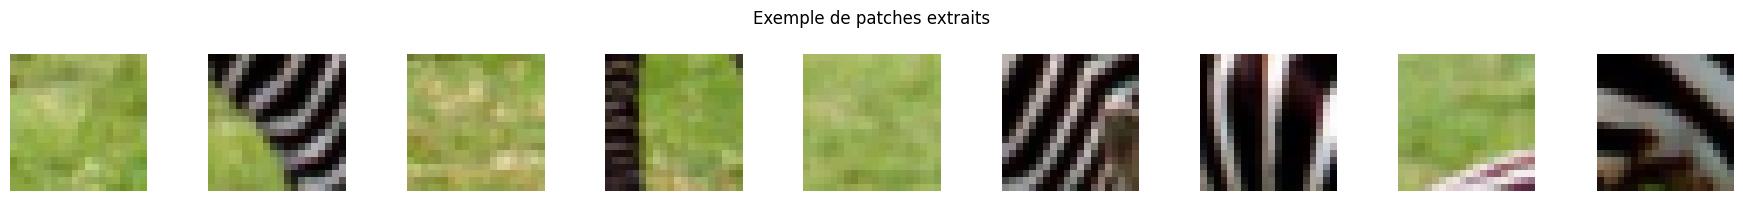

In [41]:
import random

# image 0-1 en entrée
patches = extract_patches(real_img01, patch_size, stride)  # (N, C*patch_size*patch_size)
N, D = patches.shape
C = real_img.shape[0]

# Sélection aléatoire de quelques patches
num_display = 9
indices = random.sample(range(N), num_display)

# Affichage
fig, axes = plt.subplots(1, num_display, figsize=(num_display * 2, 2))
for ax, idx in zip(axes, indices):
    vec = patches[idx]
    img_patch = vec.view(C, patch_size, patch_size).permute(1, 2, 0).cpu().numpy()
    # Si vos patches sont normalisés [0,1], on les affiche directement
    ax.imshow(img_patch)
    ax.axis('off')
    
plt.suptitle("Exemple de patches extraits", fontsize=12)
plt.tight_layout()
plt.show()

In [42]:
import numpy as np

patch_sizes   = [3, 7, 11,20,30]                 # Plusieurs tailles de patch
start_scales  = list(range(loaded_N))      # 0 à N-1
K             = 8                          # Nombre de samples par configuration
stride        = 3                          # Votre stride défini précédemment

# Préparation  
w2_results = {ps: [] for ps in patch_sizes}  # Stocke W2 pour chaque patch_size
w2_avg     = []                              # W2 moyen par start_scale

for s in start_scales:
    w2_vals_scale = []
    for ps in patch_sizes:
        # Générer K images à partir de start_scale = s
        final_imgs = []
        for _ in range(K):
            imgs = generate_multiscale(start_scale=s, Generators=loaded_generators)
            final_imgs.append(imgs[-1].cpu().squeeze())
        # Tensor [0,1]
        fake_tensor01 = (torch.stack(final_imgs).clamp(-1,1) + 1) / 2

        # Extraire patches et convertir en float64
        fake_patches = torch.cat(
            [extract_patches(img, ps, stride) for img in fake_tensor01],
            dim=0
        ).double()
        real_patches = extract_patches(real_img01, ps, stride).double()

        # Paramètres Gaussiens
        mu_f, S_f = get_gaussian_params(fake_patches)
        mu_r, S_r = get_gaussian_params(real_patches)

        # Calcul W2
        w2 = wasserstein_2_gaussian_eig(mu_r, S_r, mu_f, S_f, eps=1e-12, debug=False)
        w2_results[ps].append(w2.item())
        w2_vals_scale.append(w2.item())

    # Moyenne sur toutes les tailles de patch pour ce start_scale
    w2_avg.append(np.mean(w2_vals_scale))

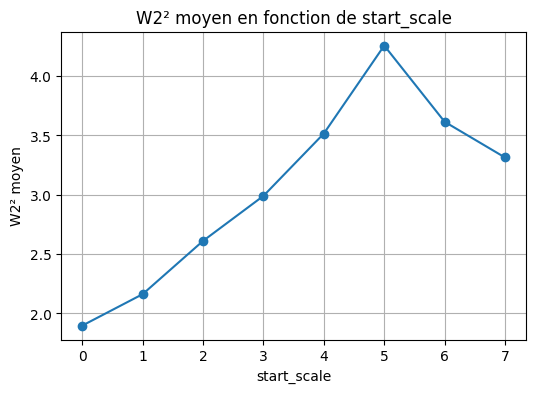

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(start_scales, w2_avg, marker='o')
plt.xlabel('start_scale')
plt.ylabel('W2² moyen')
plt.title('W2² moyen en fonction de start_scale')
plt.grid(True)
plt.show()

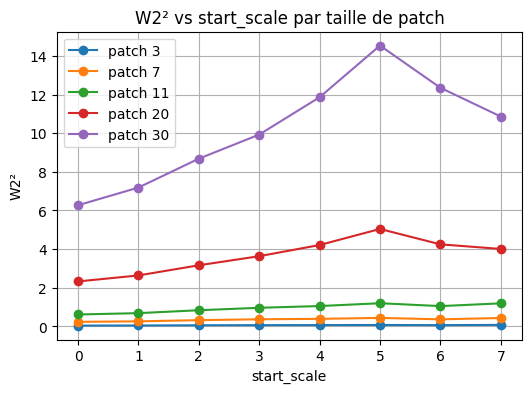

In [44]:
plt.figure(figsize=(6,4))
for ps in patch_sizes:
    plt.plot(start_scales, w2_results[ps], marker='o', label=f'patch {ps}')
plt.xlabel('start_scale')
plt.ylabel('W2²')
plt.title('W2² vs start_scale par taille de patch')
plt.legend()
plt.grid(True)
plt.show()

### SIFID CLASSIQUE : 

    Inconvénients : On prend des grands patch de notre image (min 50x50) cela en fait pas beacoup d'indépendant déjà. Et pour les passer dans Inception V3 on doit les upscale jusqu'à 299x299 (énorme distorsion selon moi)



In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import random
import numpy as np

# --------------------------------------------------------------------
# 1) PREPARE A “TRUNCATED” Inception-v3 THAT OUTPUTS POOL3 FEATURES (2048-dim)
# --------------------------------------------------------------------
class InceptionV3_Pool3(nn.Module):
    """
    Wrap torchvision's Inception-v3, cutting off right before the final
    classification layer so you can grab the 2048-dim pool3 features.
    """
    def __init__(self, device='cpu'):
        super().__init__()
        inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, transform_input=False)
        inception.eval()
        
        # We only need all layers up through the last pooling layer (pool3).
        # Officially: Inception’s features: conv1 → ... → mixed_7c → AdaptiveAvgPool2d → dropout → fc
        # We cut right after the last pooling (AdaptiveAvgPool2d).
        layers = []
        # “Conv2d_1a_3x3” ... through “Mixed_7c” are stored as inception.features in torchvision
        for name, module in inception.named_children():
            if name == 'AuxLogits' or name == 'fc': 
                # skip the aux classifier & final fc
                continue
            layers.append(module)
            # Once we append “inception.Mixed_7c” and “inception.avgpool”, we break.
            if name == 'avgpool':
                break
        
        self.trunk = nn.Sequential(*layers)
        self.device = device
        self.to(device)
    
    def forward(self, x):
        """
        Input x: Tensor of shape (B, 3, 299, 299), normalized as Inception‐v3 expects.
        Output: Tensor of shape (B, 2048) – the pool3 features.
        """
        with torch.no_grad():
            # Inception‐v3 expects input in [-1, 1] or [0, 1] transformed by its own normalization.
            # torchvision’s pretrained Inception expects inputs normalized by:
            #   mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
            # and each pixel in [0,1]. We’ll handle that in our patch preprocessing below.
            x = self.trunk(x)             # e.g. (B, 2048, 1, 1) if avgpool is AdaptiveAvgPool2d
            x = torch.flatten(x, 1)       # (B, 2048)
        return x

# Instantiate one Inception model to extract pool3 features:
device = torch.device('cpu')
inception_model = InceptionV3_Pool3(device=device)
inception_model.eval()

# --------------------------------------------------------------------
# 2) DEFINE A PATCH EXTRACTOR (random or grid-based)
# --------------------------------------------------------------------
def extract_random_patches(img: torch.Tensor, 
                           patch_size: int, 
                           num_patches: int, 
                           debug: bool=False):
    """
    img: Tensor of shape (C, H, W), with values in [0,1] or [-1,1].
    patch_size: int, e.g. 50 (meaning we’ll take 50×50 pixel crops).
    num_patches: how many random patches to sample.
    Returns a Tensor of shape (num_patches, C, patch_size, patch_size).
    """
    C, H, W = img.shape
    patches = []
    for _ in range(num_patches):
        # Random top-left corner for a patch
        top = random.randint(0, H - patch_size)
        left = random.randint(0, W - patch_size)
        patch = img[:, top:top+patch_size, left:left+patch_size]  # (C, patch_size, patch_size)
        patches.append(patch)
    
    patches = torch.stack(patches, dim=0)  # (num_patches, C, patch_size, patch_size)
    if debug:
        print("Extracted patches shape:", patches.shape)
    return patches

# --------------------------------------------------------------------
# 3) SET UP TRANSFORMS TO RESIZE & NORMALIZE PATCHES FOR INCEPTION
# --------------------------------------------------------------------
inception_preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    # If your patches are in [-1,1], shift to [0,1] first, then normalize:
    transforms.Lambda(lambda t: (t + 1) / 2 if t.min() < 0 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def preprocess_patches_for_inception(patches: torch.Tensor):
    """
    patches: Tensor (N, C, patch_size, patch_size), in [0,1] or [-1,1].
    Returns: Tensor (N, 3, 299, 299) ready for Inception.
    """
    # Apply the same resize+normalize to each patch
    N = patches.shape[0]
    processed = torch.zeros((N, 3, 299, 299), device=patches.device, dtype=torch.float32)
    for i in range(N):
        processed[i] = inception_preprocess(patches[i])
    return processed

# --------------------------------------------------------------------
# 4) FUNCTION TO COMPUTE SIFID COVERING ONE REAL VS ONE GENERATED IMAGE
# --------------------------------------------------------------------
def compute_sifid(real_img: torch.Tensor,
                  fake_img: torch.Tensor,
                  patch_size: int    = 50,
                  num_patches: int   = 100,
                  eps: float         = 1e-12):
    """
    real_img, fake_img: Tensors of shape (C, H, W) with values in [-1,1] or [0,1].
      (If in [-1,1], this code will shift to [0,1] in preprocess.)
    patch_size: size of crop (e.g. 50x50).
    num_patches: how many random patches to sample from each image.
    Returns: SIFID^2 = W2^2 between Inception‐pool3 features of real vs fake.
    """
    device = real_img.device
    
    # 1) Extract random patches from each image (float32)
    real_patches = extract_random_patches(real_img.clamp(-1,1), 
                                          patch_size, num_patches)  # (N, C, ps, ps)
    fake_patches = extract_random_patches(fake_img.clamp(-1,1), 
                                          patch_size, num_patches)

    # 2) Preprocess for Inception (resize+normalize)
    real_inp = preprocess_patches_for_inception(real_patches.to(device))  # (N,3,299,299)
    fake_inp = preprocess_patches_for_inception(fake_patches.to(device))

    # 3) Run through Inception to get pool3 features (2048 dim)
    #    InceptionV3_Pool3 already returns (N, 2048)
    with torch.no_grad():
        feat_real = inception_model(real_inp)
        feat_fake = inception_model(fake_inp)

    # 4) Convert to double precision for stable covariance
    feat_real = feat_real.double()
    feat_fake = feat_fake.double()

    # 5) Compute mean & covariance
    mu_r, Sigma_r = get_gaussian_params(feat_real)  # from your helper
    mu_f, Sigma_f = get_gaussian_params(feat_fake)

    # 6) Compute W2^2 (Fréchet) between the two Gaussians
    w2sq = wasserstein_2_gaussian_eig(mu_r, Sigma_r, mu_f, Sigma_f,
                                      eps=eps, debug=True)
    # Clamp in case of small negative numeric drift
    return float(torch.clamp(w2sq, min=0.0).item())


fake11 = generate_multiscale(start_scale=loaded_N-1, Generators=loaded_generators)[-1].cpu().squeeze()
fake01 = (fake11.clamp(-1, 1) + 1) / 2


real = real_img01.to(device)         # (3, H, W), values in [0,1] or [-1,1]
fake = fake01[0].to(device)   # take the first fake sample (3, H, W)

sifid_value = compute_sifid(real, real,
                           patch_size=50,
                           num_patches=1000,   # you can sample more for stability
                           eps=1e-12)
print("SIFID^2 (W2^2) between real and real:", sifid_value)


moyenne diff = 0.3627207642297169
trace term = 7.171345894729281
SIFID^2 (W2^2) between real and real: 7.534066658958999


In [46]:
inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, transform_input=False).to(device)
inception.eval()

# Choose a layer whose activation map we will use as patch-features.
# For torchvision Inception-v3, use 'Mixed_7c' or an earlier mixed block.
# We register a forward hook to capture its output.
layer_name = 'Mixed_7c'
features_real = []
features_fake = []

def get_module_by_name(model, name):
    for n, module in model.named_modules():
        if n == name:
            return module
    raise ValueError(f"Layer {name} not found")

# Hook function will collect activation maps
def hook_fn_real(module, input, output):
    # output shape: (B, C, H', W')
    feat = output.detach()  # (1, C, H', W')
    # Flatten spatial dims: (C, H'*W') -> (H'*W', C)
    B, C, Hf, Wf = feat.shape
    feat = feat.view(B, C, Hf * Wf).permute(0, 2, 1).squeeze(0)  # (H'*W', C)
    features_real.append(feat)

def hook_fn_fake(module, input, output):
    B, C, Hf, Wf = output.shape
    feat = output.detach().view(B, C, Hf * Wf).permute(0, 2, 1).squeeze(0)
    features_fake.append(feat)

# Register hooks
layer_module = get_module_by_name(inception, layer_name)
hook_handle_real = layer_module.register_forward_hook(hook_fn_real)
hook_handle_fake = layer_module.register_forward_hook(hook_fn_fake)

# Preprocessing for full image: resize to 299x299 and normalize
preprocess_full = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Lambda(lambda t: (t + 1) / 2 if t.min() < 0 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [47]:
# Cell 3: Compute Patch-FID (W2) via feature maps for one real vs one fake

def compute_patch_fid_feature_map(real_img, fake_img, eps=1e-12):
    """
    real_img, fake_img: Tensors of shape (C, H, W), in [-1,1] or [0,1].
    Returns: patch-FID^2 (W2^2) between feature-map distributions.
    """
    # Clear previous feature lists
    features_real.clear()
    features_fake.clear()

    # Preprocess and forward-pass real image
    inp_real = preprocess_full(real_img.unsqueeze(0).to(device))
    _ = inception(inp_real)
    feat_real = features_real[-1].double()  # (N_real_patches, D)

    # Preprocess and forward-pass fake image
    features_fake.clear()
    inp_fake = preprocess_full(fake_img.unsqueeze(0).to(device))
    _ = inception(inp_fake)
    feat_fake = features_fake[-1].double()  # (N_fake_patches, D)

    # Compute Gaussian params
    mu_r, Sigma_r = get_gaussian_params(feat_real)
    mu_f, Sigma_f = get_gaussian_params(feat_fake)

    # Compute W2^2
    w2sq = wasserstein_2_gaussian_eig(mu_r, Sigma_r, mu_f, Sigma_f, eps=eps)
    return float(w2sq.item())

# Remove hooks after use (when no longer needed)
# hook_handle_real.remove()
# hook_handle_fake.remove()

fake11 = generate_multiscale(start_scale=loaded_N-1, Generators=loaded_generators)[-1].cpu().squeeze()
fake01 = (fake11.clamp(-1, 1) + 1) / 2



# Example usage:
real = real_img01  # (3,H,W)
fake = fake01  # take one generated sample
patch_fid = compute_patch_fid_feature_map(real, fake)
print("Patch-FID^2 via feature map:", patch_fid)


moyenne diff = 20.2581803727485
trace term = 128.6519181408944
Patch-FID^2 via feature map: 148.9100985136429
